<a href="https://colab.research.google.com/github/tombackert/ml-stuff/blob/main/Brain_tumor_MRI_Accuracy_99_and_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1608934%2F2645886%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240302%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240302T015738Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D78515fbbc859770e7d2a7842529a3c1674a9e277d5a367024e6a7f1478212da2315e8e28f0bdc787638cdd3afdc199528d830ea89bfe781c1beac886b0bb8f52a85499793c41c041093c5e38af8c1e466101c51a4e847b8ee9623e2d47f4d8d380163f6e6113b56bda044224ee7e36e24cb53dd8f791fd69a037b61f72fe531e9d8bae496ebaa785bf2ded38817a338548e2269d5c65e56b1bd995911ed32c9260044b35ba702d78d6a65742ddeeb1556fdf38e3a2200896d0fa41767dd55ca5bd1741d8942f414b2e754619c7aad8a763667a15b4b2bd96ec7c1971964881f30ec7476a2eb11bdbe6205115b2fb9ebb13ef04263d8fa8fe937d9a69f33d44c9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# 1. Import needed libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 2. Preprocessing

## 2.1 Load data

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')

In [ ]:
tr_df

In [ ]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [ ]:
ts_df

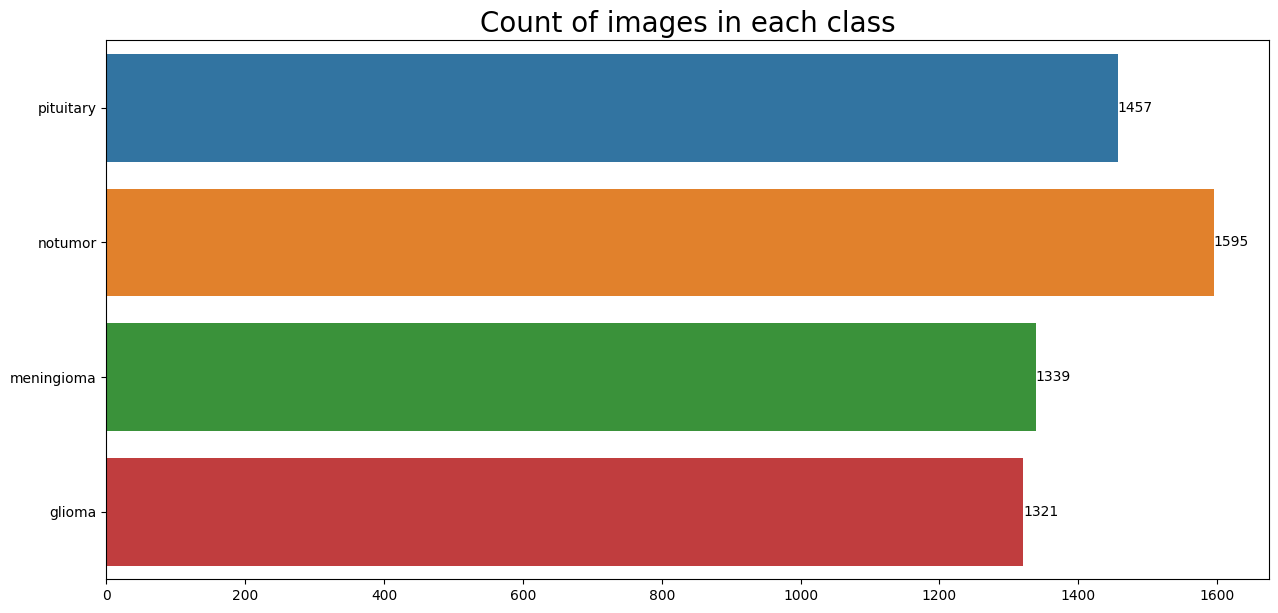

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

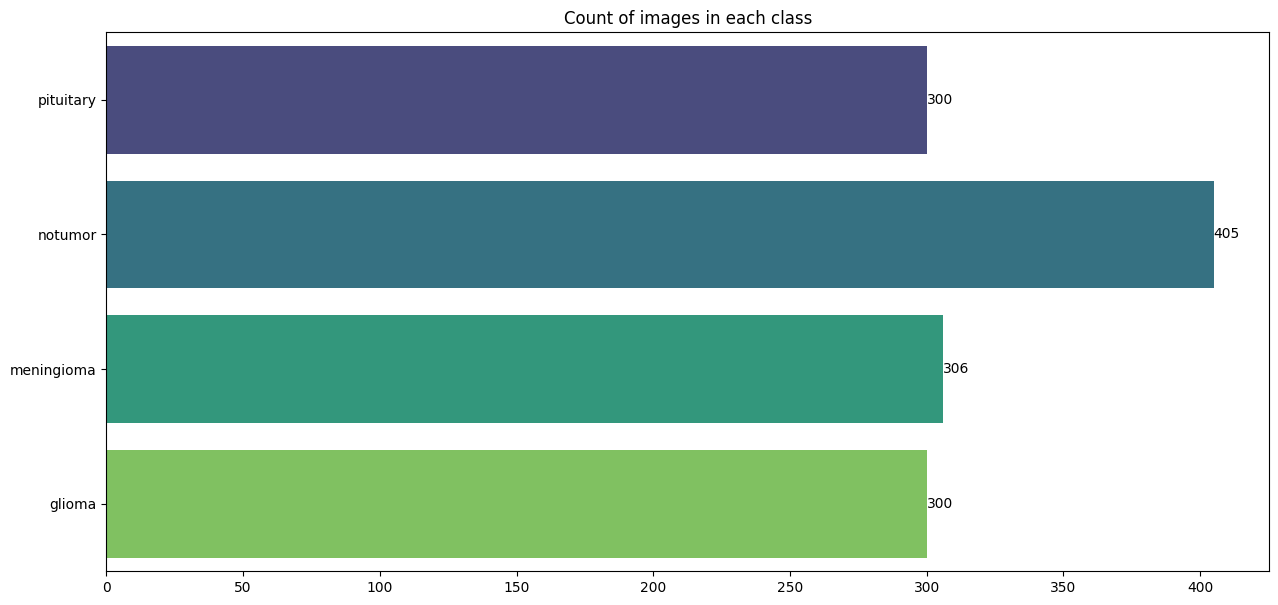

In [ ]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [ ]:
valid_df

## 2.3 Data preprocessing

In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

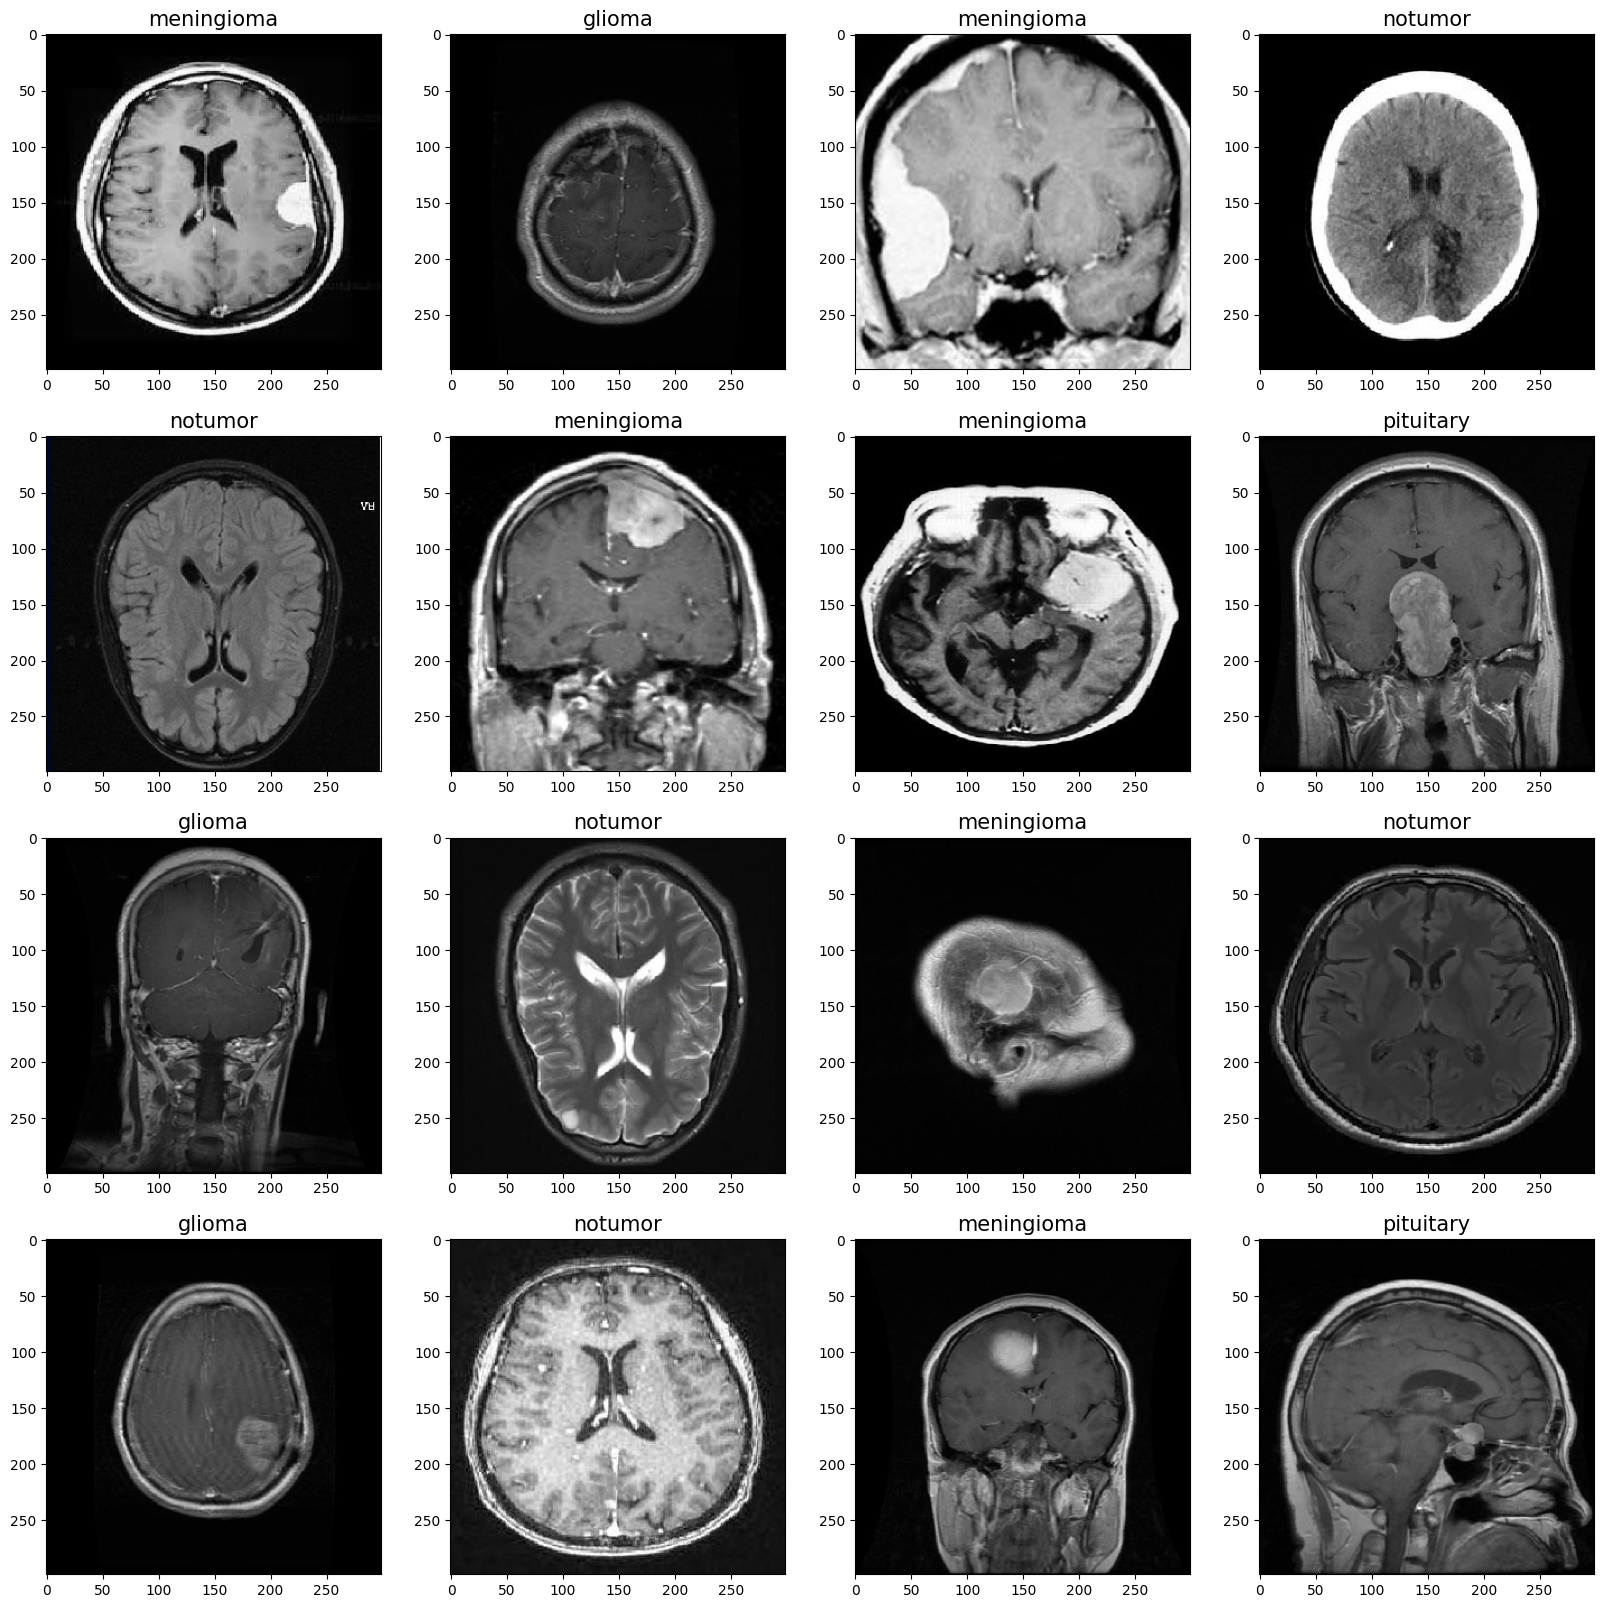

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [ ]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False,
                                            weights= "imagenet",
                                            input_shape= img_shape,
                                            pooling= 'max')


model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [ ]:
with tf.device(device_name):
    hist = model.fit(tr_gen,
                     epochs=10,
                     validation_data=valid_gen,
                     shuffle= False)

Epoch 1/10
179/179 [==============================] - 87s 487ms/step - loss: 0.0155 - accuracy: 0.9951 - precision_1: 0.9953 - recall_1: 0.9949 - val_loss: 0.1217 - val_accuracy: 0.9695 - val_precision_1: 0.9695 - val_recall_1: 0.9695
Epoch 2/10
179/179 [==============================] - 88s 488ms/step - loss: 0.0167 - accuracy: 0.9949 - precision_1: 0.9954 - recall_1: 0.9944 - val_loss: 0.1383 - val_accuracy: 0.9756 - val_precision_1: 0.9756 - val_recall_1: 0.9756
Epoch 3/10
179/179 [==============================] - 88s 489ms/step - loss: 0.0141 - accuracy: 0.9967 - precision_1: 0.9968 - recall_1: 0.9965 - val_loss: 0.0237 - val_accuracy: 0.9908 - val_precision_1: 0.9908 - val_recall_1: 0.9908
Epoch 4/10
179/179 [==============================] - 88s 488ms/step - loss: 0.0072 - accuracy: 0.9974 - precision_1: 0.9974 - recall_1: 0.9974 - val_loss: 0.0425 - val_accuracy: 0.9878 - val_precision_1: 0.9878 - val_recall_1: 0.9878
Epoch 5/10
179/179 [==============================] - 88s 48

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

## 4.1 Visualize model performance

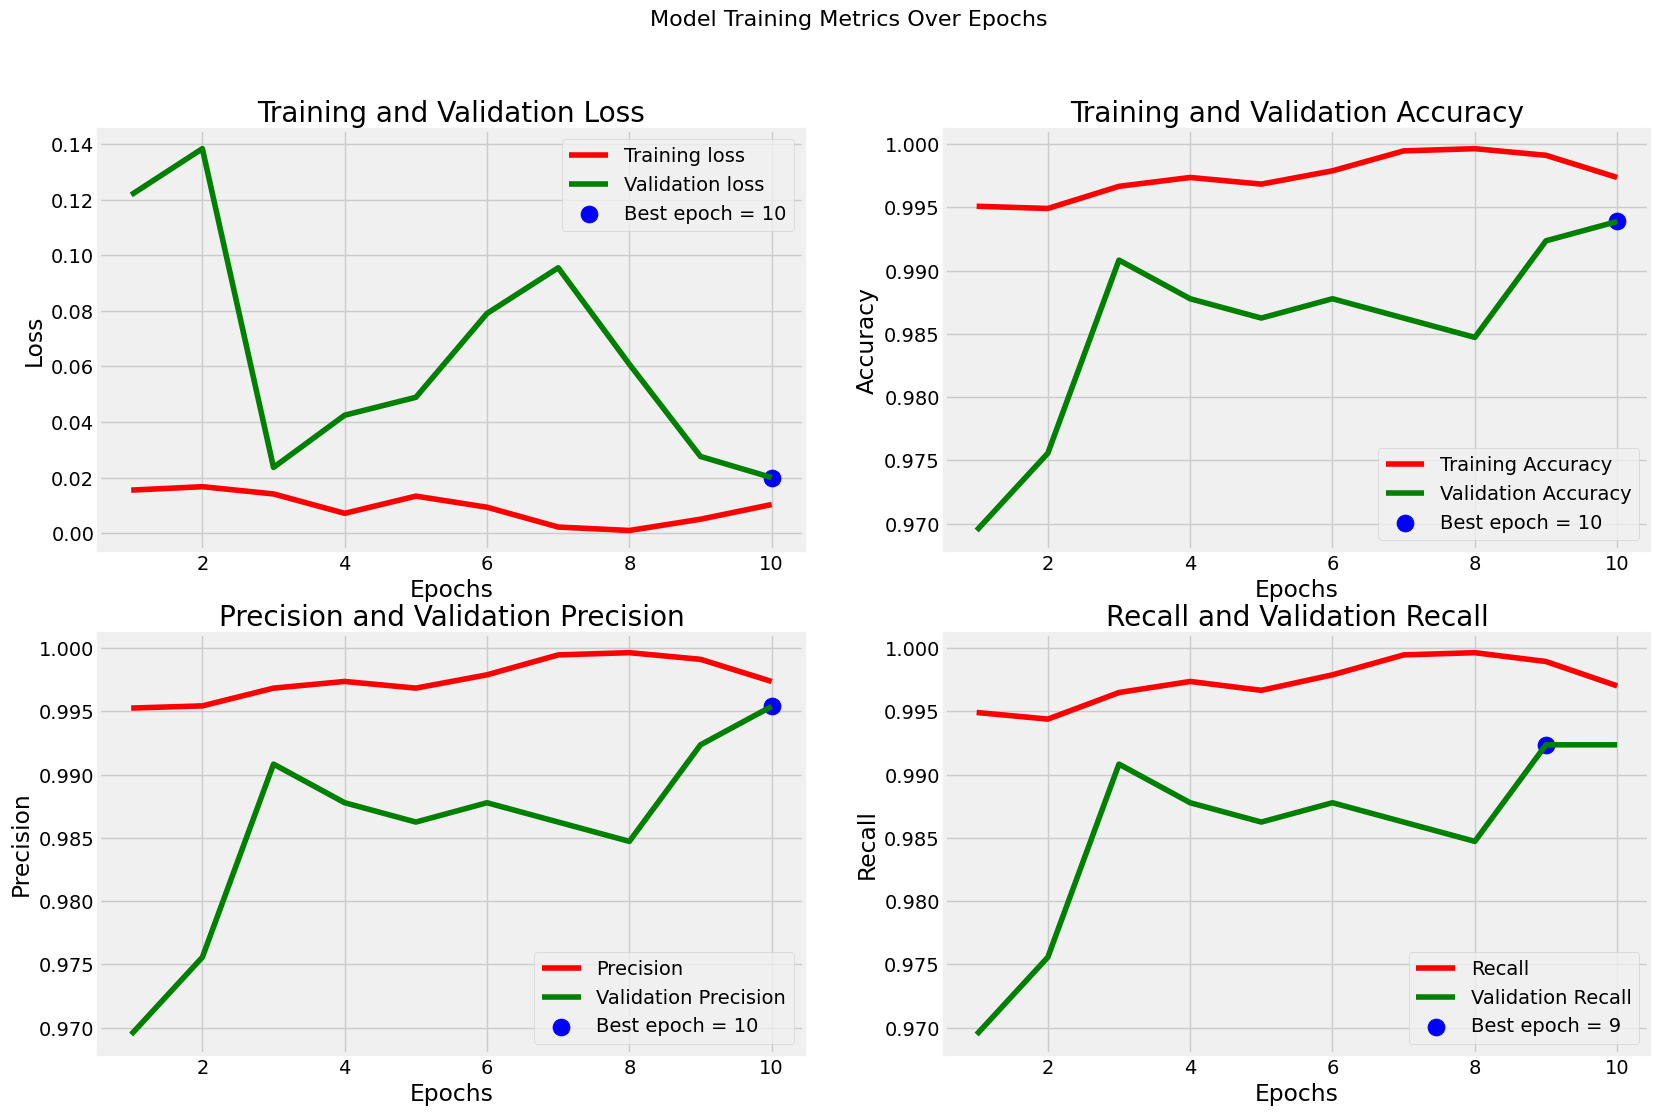

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision_1']
tr_recall = hist.history['recall_1']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision_1']
val_recall = hist.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [ ]:
tr_gen_copy = tr_gen
valid_gen_copy = valid_gen
ts_gen_copy = ts_gen

In [ ]:



train_score = model.evaluate(tr_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(ts_gen_copy, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

41/41 [==============================] - 4s 90ms/step - loss: 0.0558 - accuracy: 0.9893 - precision_1: 0.9908 - recall_1: 0.9878
Train Loss: 0.0025
Train Accuracy: 99.91%
--------------------
Validation Loss: 0.0273
Validation Accuracy: 99.39%
--------------------
Test Loss: 0.0558
Test Accuracy: 98.93%


In [ ]:
preds = model.predict(ts_gen_copy)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 4s 69ms/step


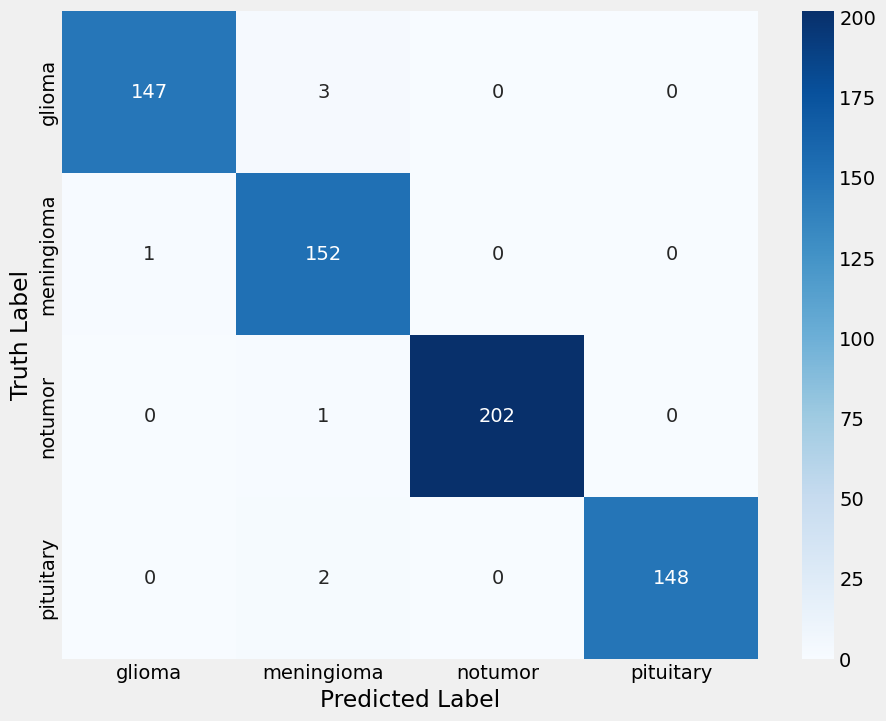

In [ ]:
cm = confusion_matrix(ts_gen_copy.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen_copy.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       150
           1       0.96      0.99      0.98       153
           2       1.00      1.00      1.00       203
           3       1.00      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



## 5.2 Testing

In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 1s 1s/step


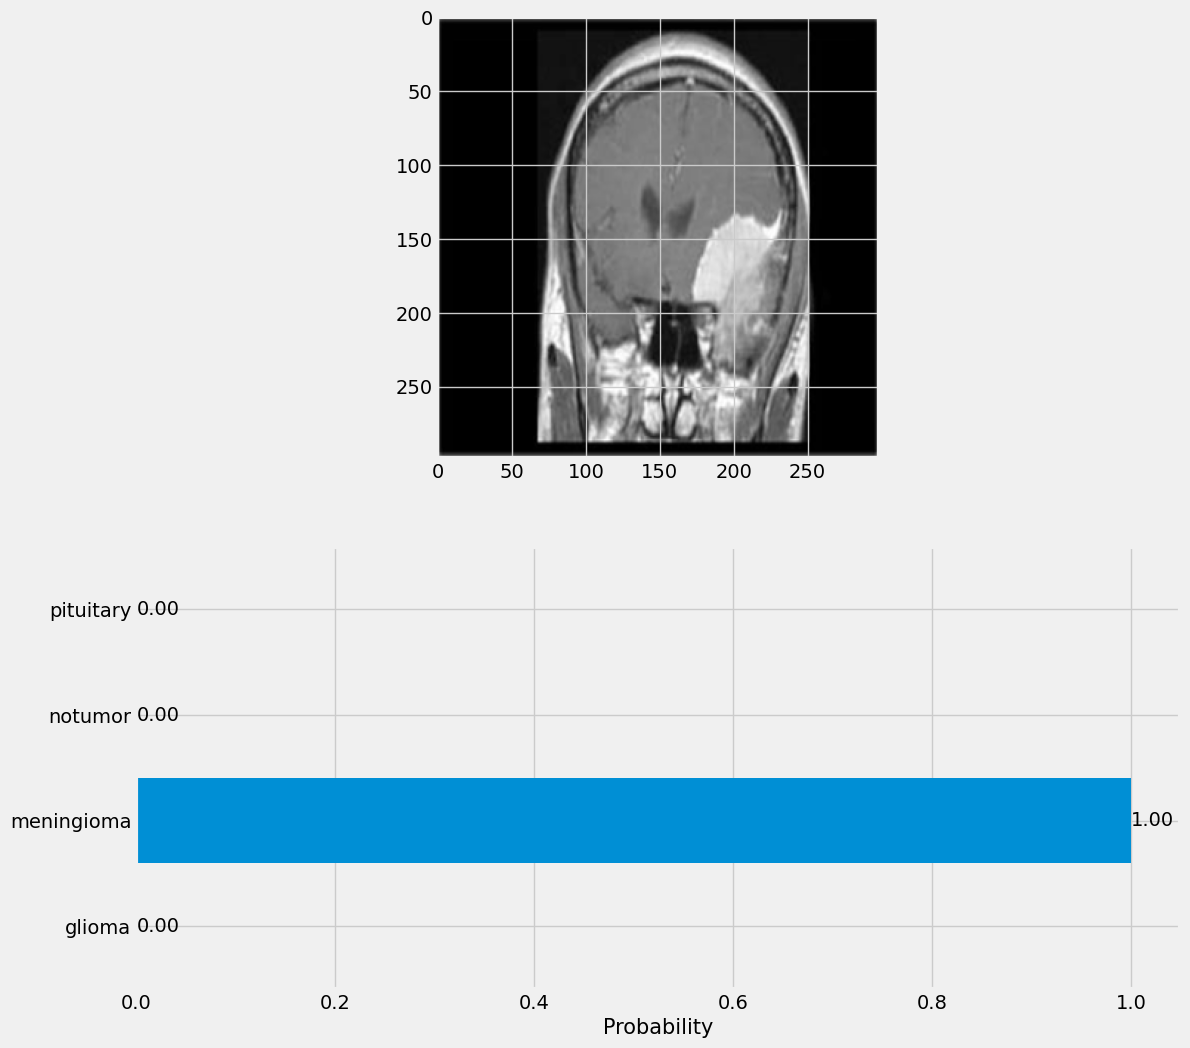

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')

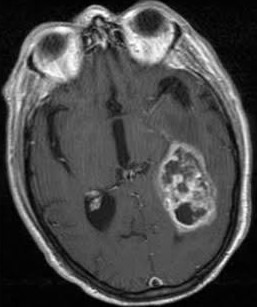

In [ ]:

img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0001.jpg"

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 22ms/step
Predicted: [[0. 0. 0. ... 0. 0. 0.]]


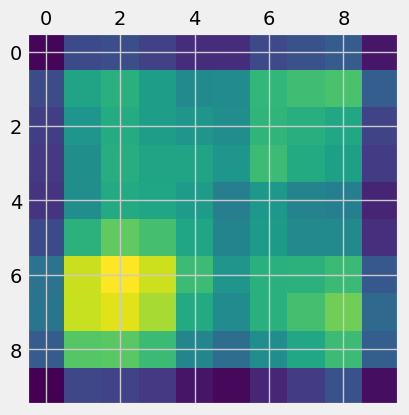

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = base_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<Figure size 640x480 with 0 Axes>

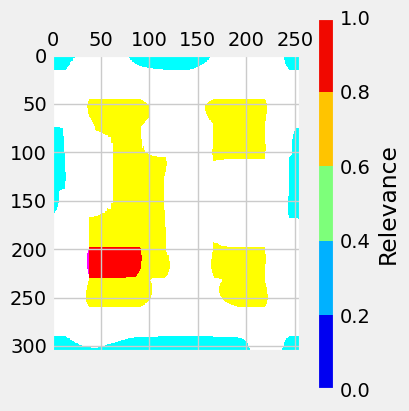

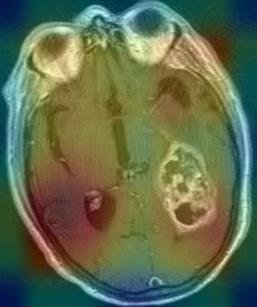

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    colormap = mpl.colormaps["jet"]
    cm = colormap

    # Use RGB values of the colormap
    cm_colors = cm(np.arange(256))[:, :3]
    cm_heatmap = cm_colors[heatmap]

    # Create an image with RGB colorized heatmap
    cm_heatmap = keras.utils.array_to_img(cm_heatmap)
    cm_heatmap = cm_heatmap.resize((img.shape[1], img.shape[0]))
    cm_heatmap = keras.utils.img_to_array(cm_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = cm_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)


    # Display Grad CAM
    plt.figure()
    plt.matshow(cm_heatmap)
    plt.colorbar(mpl.cm.ScalarMappable(cmap=cm), label="Relevance", boundaries=np.linspace(0, 1, 6), ax=plt.gca())
    plt.show()

     # Save the superimposed image
    superimposed_img.save(cam_path)

    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)